# Model Development and Apparent Validation

In [ ]:
source("notebooks/initialize-data-analysis.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'yardstick'

The following object is masked from 'package:readr':

    spec

Loading required package: rms
Loading required package: Hmisc

Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

# Penalized Likelihood Methods

## Backwards Stepwise Logistic Regression (obsolete)

In [ ]:
# library(StepReg)
# run_stepwise_logit <- function(data, formula) {
#   stepwise(
#     formula,
#     data = data,
#     type = "logit",
#     include = NULL,
#     strategy = "backward",
#     metric = "AIC"
#   )
# }

# stepwise_model <- data_patient_transformed |>
#   select(all_of(variables_to_screen_short), flag_ADR_TP_ID) |>
#   run_stepwise_logit(
#     formula = flag_ADR_TP_ID ~ .
#   )

# stepwise_model

In [ ]:
# run_step_AIC <- function(data, formula) {
#   MASS::stepAIC(
#     glm(
#       formula = formula,
#       data = data
#     ),
#     direction = "backward",
#     trace = FALSE
#   )
# }

# stepwise_model_MASS <- data_patient_transformed |>
#   select(all_of(predictor_transformed), flag_ADR_TP_ID) |>
#   run_step_AIC(
#     formula = flag_ADR_TP_ID ~ .
#   )

# stepwise_model_MASS |> str()

## LASSO Variable Selection (obsolete, see Elastic Net Regularization)

In [ ]:
# library(glmnet)
# predictor_matrix <- data_patient_complete |>
#   select(all_of(predictor_list)) |>
#   as.matrix()
# response_matrix <- data_patient_complete |>
#   select(flag_ADR_TP_ID) |>
#   pull()

# lasso_fit <- glmnet(
#   x = predictor_matrix,
#   y = response_matrix,
#   family = "binomial",
#   alpha = 1
# )

# cv_lasso_fit <- cv.glmnet(
#   x = predictor_matrix,
#   y = response_matrix,
#   family = "binomial",
#   alpha = 1,
#   nfolds = 5
# )

# coef(lasso_fit, s = cv_lasso_fit$lambda.min)@i |> length() - 1

## Elastic Net Regularization

In [ ]:
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.5      ✔ recipes      1.0.10
✔ dials        1.2.1      ✔ rsample      1.2.1 
✔ infer        1.0.7      ✔ tune         1.2.1 
✔ modeldata    1.3.0      ✔ workflows    1.1.4 
✔ parsnip      1.2.1      ✔ workflowsets 1.1.0 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()    masks purrr::discard()
✖ dplyr::filter()      masks stats::filter()
✖ recipes::fixed()     masks stringr::fixed()
✖ dplyr::lag()         masks stats::lag()
✖ yardstick::spec()    masks readr::spec()
✖ Hmisc::src()         masks dplyr::src()
✖ recipes::step()      masks stats::step()
✖ Hmisc::summarize()   masks dplyr::summarize()
✖ parsnip::translate() masks Hmisc::translate()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

In [ ]:
rec <- recipe(flag_ADR_TP_ID ~ ., data = data_patient_screen) |>
  step_dummy(all_nominal_predictors())

model_elastic <- logistic_reg(penalty = tune(), mixture = tune()) |>
  set_engine("glmnet") |>
  set_mode("classification")

model_workflow <- workflow() |>
  add_model(model_elastic) |>
  add_recipe(rec)

tune_params <- model_workflow |>
  extract_parameter_set_dials() |>
  update(
    penalty = penalty(range = c(-3, 0)),
    mixture = mixture(range = c(0.5, 1))
  ) |>
  grid_latin_hypercube(size = 1000)

tic()
plan(multisession, workers = max(min(parallel::detectCores() - 1, 12), 2))

model_tune_results <- model_workflow |>
  tune_grid(
    resamples = cross_samples,
    grid = tune_params,
    control = control_grid(save_pred = TRUE)
  )

plan(sequential)
toc()

260.825 sec elapsed

# A tibble: 4 × 6
  .metric       .estimator    mean     n std_err .config             
  <chr>         <chr>        <dbl> <int>   <dbl> <chr>               
1 brier_class   binary      0.173      6  0.0123 Preprocessor1_Model1
2 cal_intercept binary     -0.0239     6  0.147  Preprocessor1_Model1
3 cal_slope     binary      1.09       6  0.148  Preprocessor1_Model1
4 roc_auc       binary      0.785      6  0.0198 Preprocessor1_Model1

# A tibble: 14 × 3
   term                    estimate penalty
   <chr>                      <dbl>   <dbl>
 1 (Intercept)             -0.729   0.00275
 2 baseline_CLCR           -0.00553 0.00275
 3 patient_age              0.0160  0.00275
 4 baseline_PLT            -0.00787 0.00275
 5 LZD_duration_14_TRUE.    0.930   0.00275
 6 comed_heparin_TRUE.      0.822   0.00275
 7 infect_sepsis_TRUE.      0.576   0.00275
 8 dept_ICU_TRUE.           0.0302  0.00275
 9 comorb_cirr_TRUE.        0.761   0.00275
10 invasive_CRRT_TRUE.      0.399   0.00275
11 comed_enoxaparin_TRUE.   0.145   0.00275
12 LZD_route_IV_TRUE.       0       0.00275
13 infect_septicemia_TRUE.  0.199   0.00275
14 invasive_IHD_TRUE.      -0.0448  0.00275

In [ ]:
# multi_glmnet <- model_glmnet |>
#   tidy() |>
#   filter(estimate > 0) |>
#   pull(term) |>
#   str_extract(paste(variables_to_screen, collapse = "|"))

# model_glmnet_fit <-
#   logistic_reg(
#     penalty = model_accepted_flow$penalty,
#     mixture = model_accepted_flow$mixture
#   ) |>
#   set_engine("glmnet") |>
#   fit(
#     flag_ADR_TP_ID ~ .,
#     data = data_patient_screen
#   ) |>
#   tidy()

# Bayesian Methods

## Bayesian Model Selection

In [ ]:
data_patient_screen_full <- data_patient_transformed |>
  mutate(
    across(where(is.logical), as.factor)
  )

### Strategy 1-A: Screen “consensus” variables, continuous variables only (13 parameters)

In [ ]:
# multi_model <- data_patient_complete |>
#   select(all_of(predictor_list), flag_ADR_TP_ID) |>
#   run_bas_glm(
#     formula = flag_ADR_TP_ID ~ .,
#     include.always = ~1
#   )

# summary(multi_model)
# plot(multi_model)
# image(multi_model, rotate = FALSE)
# diagnostics(multi_model)

library(tictoc)

tic()
multi_model_1_A <- data_patient_transformed |>
  select(all_of(variables_to_screen_short), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = ~1,
    n.models = 2^15,
    thin = length(variables_to_screen_short),
    force.heredity = TRUE,
    method = "deterministic",
    update = 1
  )
toc()

3.636 sec elapsed

In [ ]:
library(tidymodels)
# library(probably)

model_basic_flow_1_A <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_A)) |>
  add_model(logistic_reg())

# model_full <- model_basic_flow |>
#   update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_HPM)) |>
#   fit(data = data_patient_screen)

model_full_BPM_1_A <- model_basic_flow_1_A |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_A)) |>
  fit(data = data_patient_screen_full)

# model_basic_performances <- workflow() |>
#   add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM)) |>
#   add_model(logistic_reg()) |>
#   fit_resamples(
#     resamples = cross_samples,
#     metrics = metric_set(roc_auc, brier_class, cal_intercept, cal_slope, sens, spec, ppv, npv),
#     control = control_resamples(save_pred = TRUE)
#   )

# model_basic_performances |>
#   collect_metrics()

# model_basic_performances |>
#   collect_predictions() |>
#   threshold_perf(flag_ADR_TP_ID, .pred_TRUE, thresholds = seq(0.1, 0.9, by = 0.1))

save(model_full_BPM_1_A, file = "data/model-performance/model-full-BPM-1-A.rda")

### Strategy 1-B: Force top 5, screen “consensus”, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_1_B <- data_patient_transformed |>
  select(all_of(variables_to_screen_short), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force),
    n.models = 2^15,
    thin = length(variables_to_screen_short),
    force.heredity = TRUE,
    method = "deterministic",
    update = 1
  )
toc()

0.203 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_1_B <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_B)) |>
  add_model(logistic_reg())

model_full_BPM_1_B <- model_basic_flow_1_B |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_B)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_1_B, file = "data/model-performance/model-full-BPM-1-B.rda")

### Strategy 1-C: Force top 5 (allow categorical), screen “consensus”, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_1_C <- data_patient_transformed |>
  select(all_of(variables_to_screen_short_binary), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_binary),
    n.models = 2^15,
    thin = length(variables_to_screen_short_binary),
    force.heredity = TRUE,
    method = "deterministic",
    update = 1
  )
toc()

0.196 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_1_C <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_C)) |>
  add_model(logistic_reg())

model_full_BPM_1_C <- model_basic_flow_1_C |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_C)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_1_C, file = "data/model-performance/model-full-BPM-1-C.rda")

### Strategy 1-D: Force top 3, screen “consensus”, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_1_D <- data_patient_transformed |>
  select(all_of(variables_to_screen_short_binary), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_top_3),
    n.models = 2^15,
    thin = length(variables_to_screen_short_binary),
    force.heredity = TRUE,
    method = "deterministic",
    update = 1
  )
toc()

0.629 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_1_D <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_D)) |>
  add_model(logistic_reg())

model_full_BPM_1_D <- model_basic_flow_1_D |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_1_D)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_1_D, file = "data/model-performance/model-full-BPM-1-D.rda")

### Strategy 2-A: Screen top 21 (by mean), continuous only

In [ ]:
library(tictoc)

tic()
multi_model_2_A <- data_patient_transformed |>
  select(all_of(variables_to_screen), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = ~1,
    n.models = 2^15,
    thin = length(variables_to_screen),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()

90.927 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_2_A <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_A)) |>
  add_model(logistic_reg())

model_full_BPM_2_A <- model_basic_flow_2_A |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_A)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_2_A, file = "data/model-performance/model-full-BPM-2-A.rda")

### Strategy 2-B: Force top 5, screen top 21 (by mean), continuous only

In [ ]:
library(tictoc)

tic()
multi_model_2_B <- data_patient_transformed |>
  select(all_of(variables_to_screen), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force),
    n.models = 2^15,
    thin = length(variables_to_screen),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()

81.776 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_2_B <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_B)) |>
  add_model(logistic_reg())

model_full_BPM_2_B <- model_basic_flow_2_B |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_B)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_2_B, file = "data/model-performance/model-full-BPM-2-B.rda")

### Strategy 2-C: Force top 5 (allow categorical), screen top 21 (by mean), continuous only

In [ ]:
library(tictoc)

tic()
multi_model_2_C <- data_patient_transformed |>
  select(all_of(variables_to_screen_binary), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_binary),
    n.models = 2^15,
    thin = length(variables_to_screen_binary),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()

80.849 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_2_C <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_C)) |>
  add_model(logistic_reg())

model_full_BPM_2_C <- model_basic_flow_2_C |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_C)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_2_C, file = "data/model-performance/model-full-BPM-2-C.rda")

### Strategy 2-D: Force top 3, screen top 21 (by mean), continuous only

In [ ]:
library(tictoc)

tic()
multi_model_2_D <- data_patient_transformed |>
  select(all_of(variables_to_screen), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_top_3),
    n.models = 2^15,
    thin = length(variables_to_screen),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()

64.599 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_2_D <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_D)) |>
  add_model(logistic_reg())

model_full_BPM_2_D <- model_basic_flow_2_D |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_2_D)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_2_D, file = "data/model-performance/model-full-BPM-2-D.rda")

### Strategy 3-A: Screen all, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_3_A <- data_patient_transformed |>
  select(all_of(variables_to_screen_all), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = ~1,
    n.models = 2^15, # runtime ~450s, not enough (60% cumulative probability)
    thin = length(variables_to_screen_all),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()

279.062 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_3_A <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_A)) |>
  add_model(logistic_reg())

model_full_BPM_3_A <- model_basic_flow_3_A |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_A)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_3_A, file = "data/model-performance/model-full-BPM-3-A.rda")

### Strategy 3-B: Force top 5, screen all, continuous only

In [ ]:
library(tictoc)

tic()
multi_model_3_B <- data_patient_transformed |>
  select(all_of(variables_to_screen_all), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force),
    n.models = 2^15, # runtime 300s, acceptable (85%)
    thin = length(variables_to_screen_all),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()

175.843 sec elapsed

In [ ]:
library(tidymodels)

model_basic_flow_3_B <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_B)) |>
  add_model(logistic_reg())

model_full_BPM_3_B <- model_basic_flow_3_B |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_B)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_3_B, file = "data/model-performance/model-full-BPM-3-B.rda")

### Strategy 3-C: Force top 5 (allow categorical), screen all, continuous only

210.357 sec elapsed

                       P(B != 0 | Y)       model 1       model 2      model 3
Intercept                1.000000000  1.000000e+00    1.00000000    1.0000000
LZD_duration_14TRUE      1.000000000  1.000000e+00    1.00000000    1.0000000
comed_heparinTRUE        1.000000000  1.000000e+00    1.00000000    1.0000000
infect_sepsisTRUE        1.000000000  1.000000e+00    1.00000000    1.0000000
dept_ICUTRUE             1.000000000  1.000000e+00    1.00000000    1.0000000
baseline_CLCR_30TRUE     1.000000000  1.000000e+00    1.00000000    1.0000000
patient_age              0.578576295  0.000000e+00    1.00000000    1.0000000
baseline_PLT             1.000000000  1.000000e+00    1.00000000    1.0000000
comorb_cirrTRUE          0.225394947  0.000000e+00    0.00000000    0.0000000
invasive_CRRTTRUE        0.013239264  0.000000e+00    0.00000000    0.0000000
comed_enoxaparinTRUE     0.008490130  0.000000e+00    0.00000000    0.0000000
LZD_route_IVTRUE         0.007320563  0.000000e+00    0.00000000

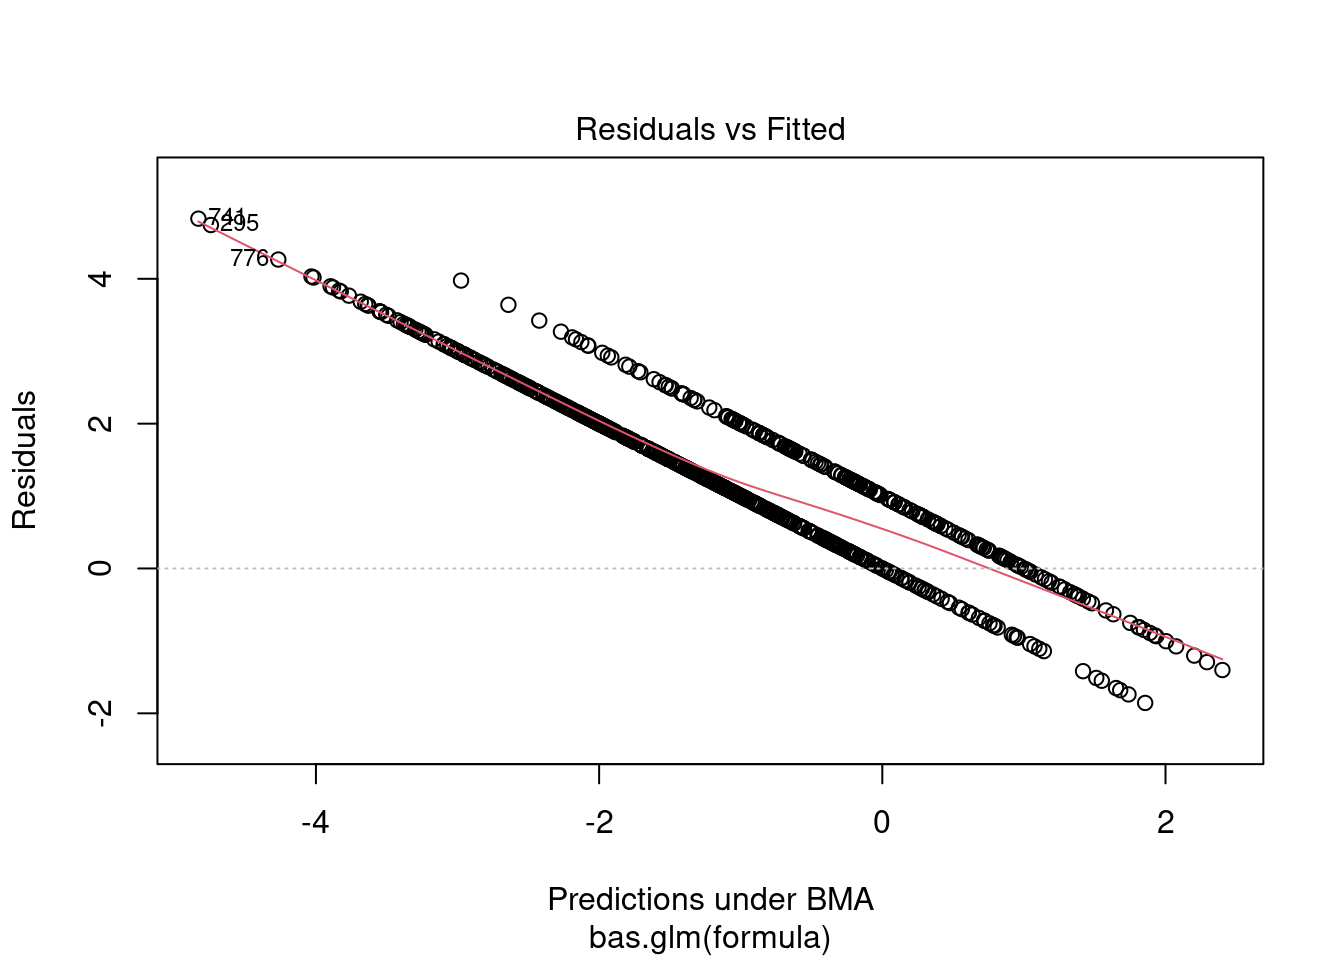

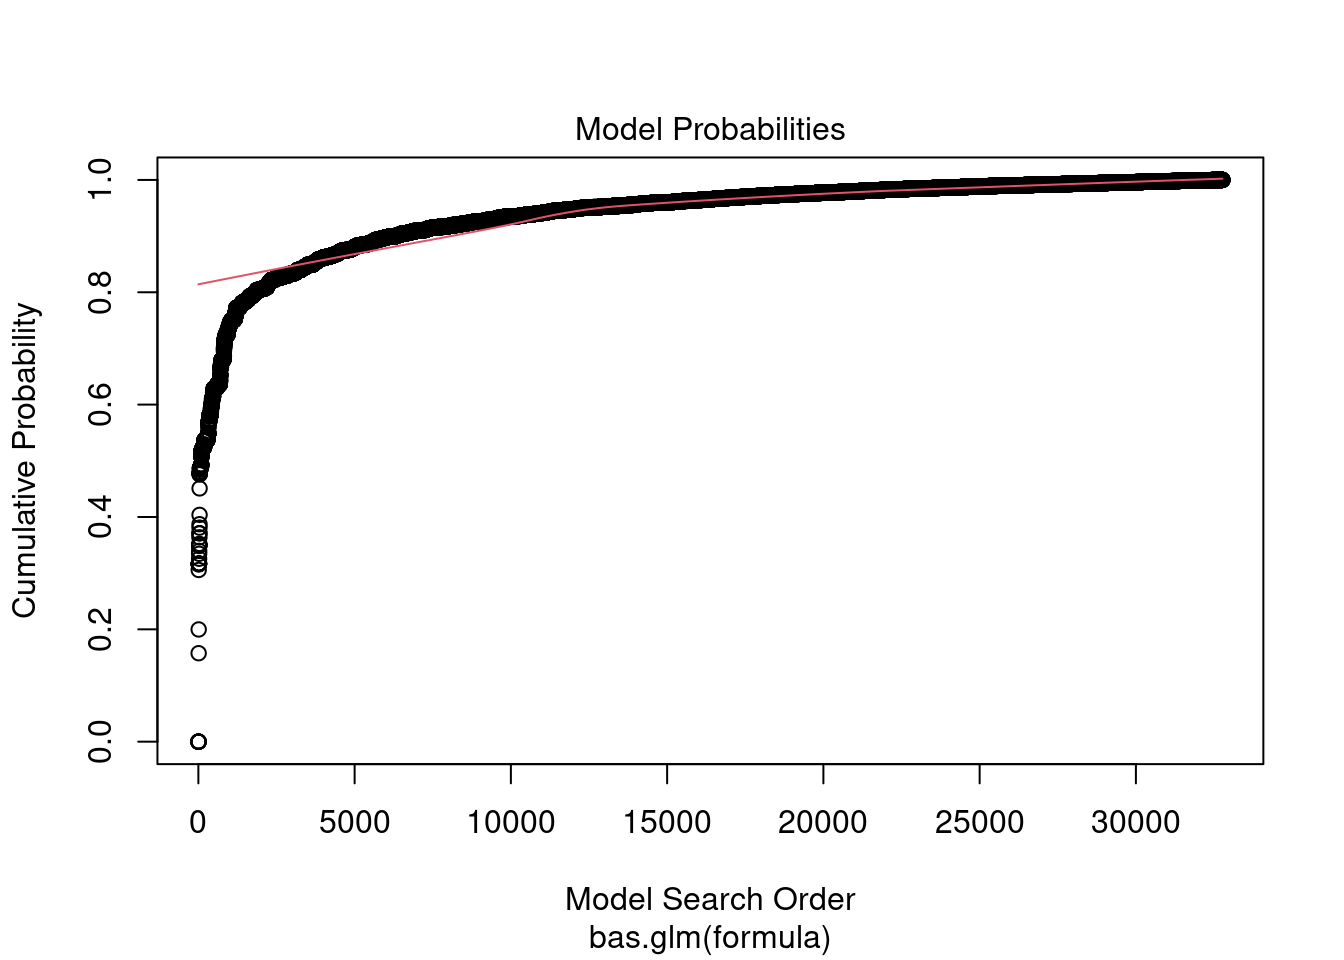

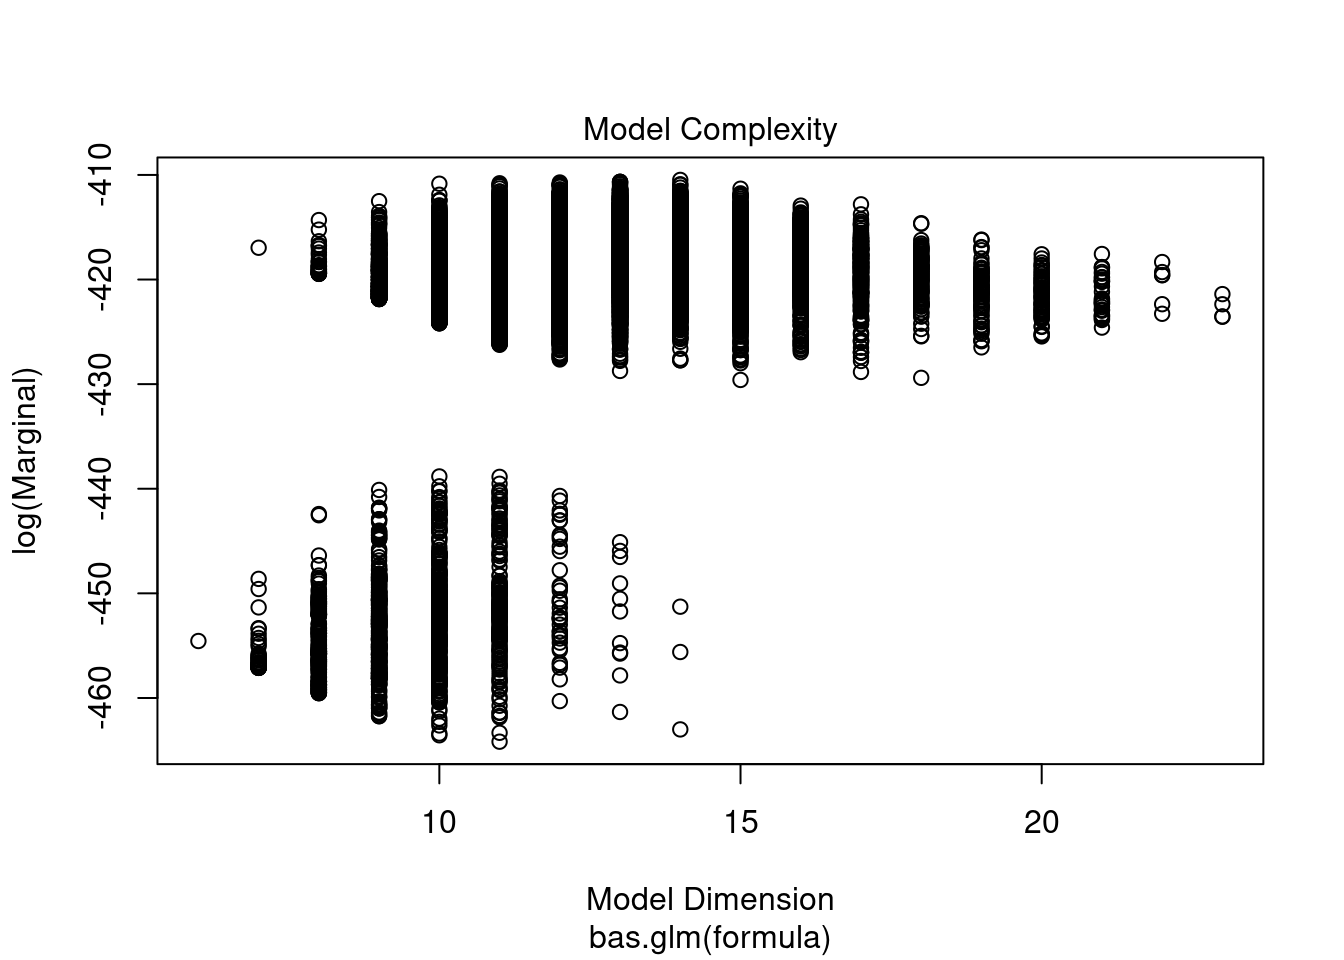

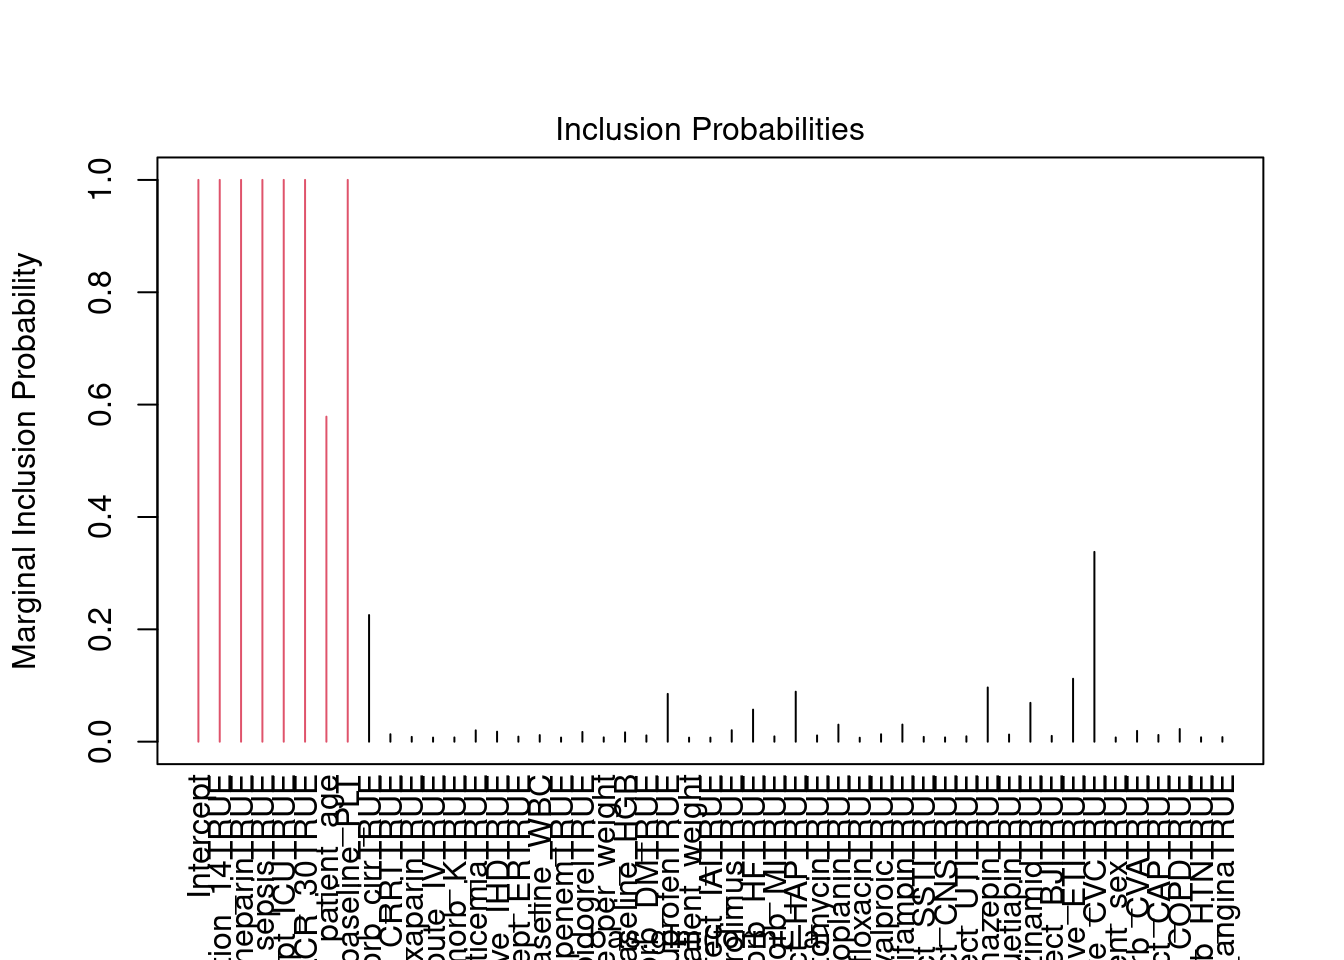

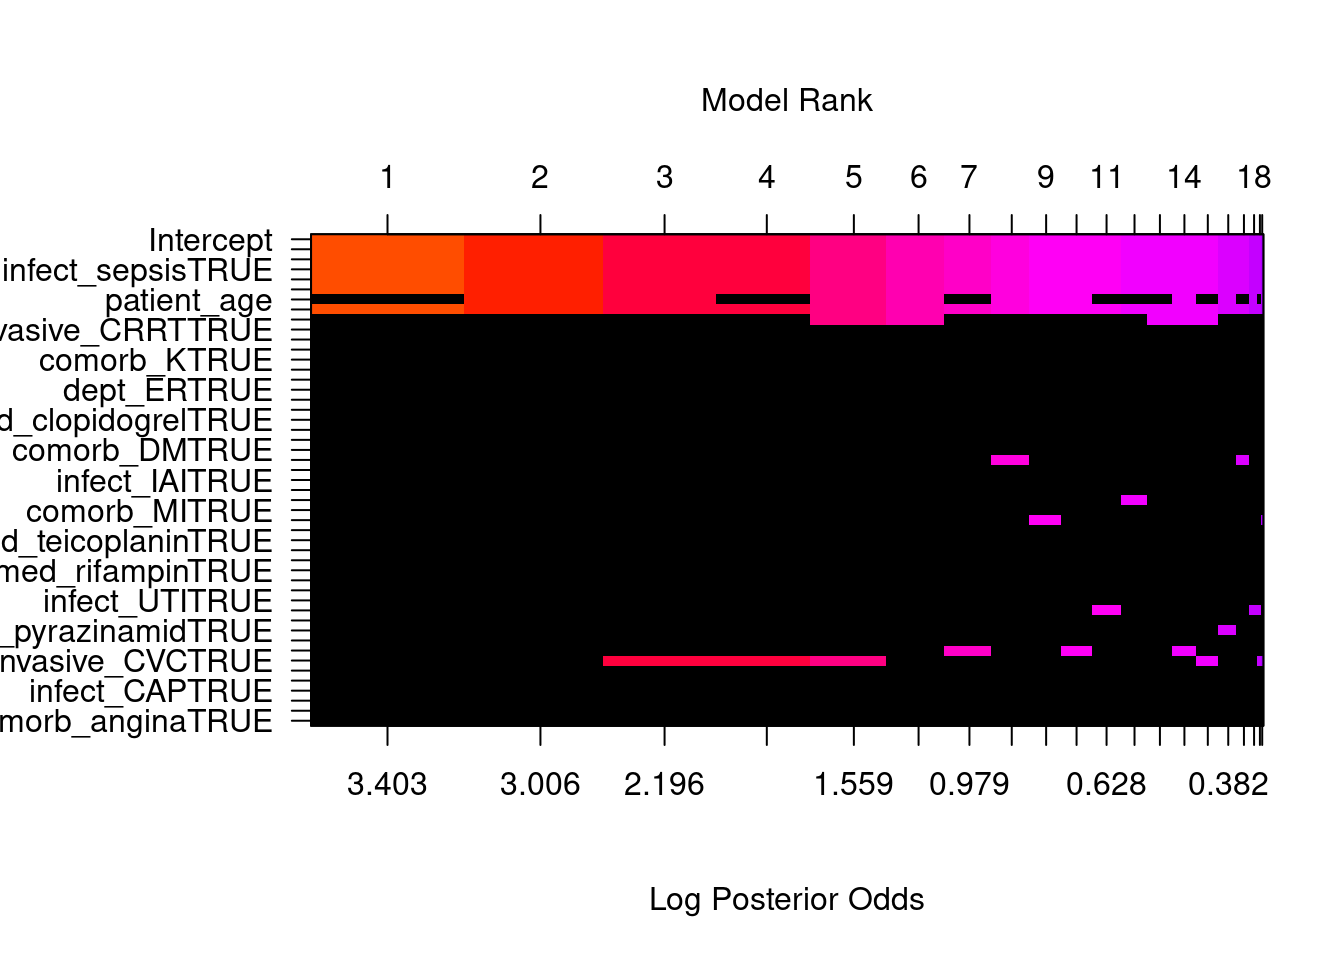

In [ ]:
library(tictoc)

tic()
multi_model_3_C <- data_patient_transformed |>
  select(all_of(variables_to_screen_all_binary), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_binary),
    n.models = 2^15, # runtime 350s, acceptable (85%)
    thin = length(variables_to_screen_all_binary),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()

In [ ]:
library(tidymodels)

model_basic_flow_3_C <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_C)) |>
  add_model(logistic_reg())

model_full_BPM_3_C <- model_basic_flow_3_C |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_C)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_3_C, file = "data/model-performance/model-full-BPM-3-C.rda")

### Strategy 3-D: Force top 3, screen all, continuous only

155.396 sec elapsed

                       P(B != 0 | Y)       model 1      model 2       model 3
Intercept                1.000000000    1.00000000    1.0000000    1.00000000
LZD_duration_14TRUE      1.000000000    1.00000000    1.0000000    1.00000000
comed_heparinTRUE        1.000000000    1.00000000    1.0000000    1.00000000
infect_sepsisTRUE        1.000000000    1.00000000    1.0000000    1.00000000
dept_ICUTRUE             0.006973531    0.00000000    0.0000000    0.00000000
baseline_CLCR            0.162135002    0.00000000    0.0000000    1.00000000
patient_age              0.865672089    1.00000000    1.0000000    0.00000000
baseline_PLT             1.000000000    1.00000000    1.0000000    1.00000000
comorb_cirrTRUE          0.136729654    0.00000000    0.0000000    0.00000000
invasive_CRRTTRUE        0.021675486    0.00000000    0.0000000    0.00000000
comed_enoxaparinTRUE     0.007108797    0.00000000    0.0000000    0.00000000
LZD_route_IVTRUE         0.006824739    0.00000000    0.0000000 

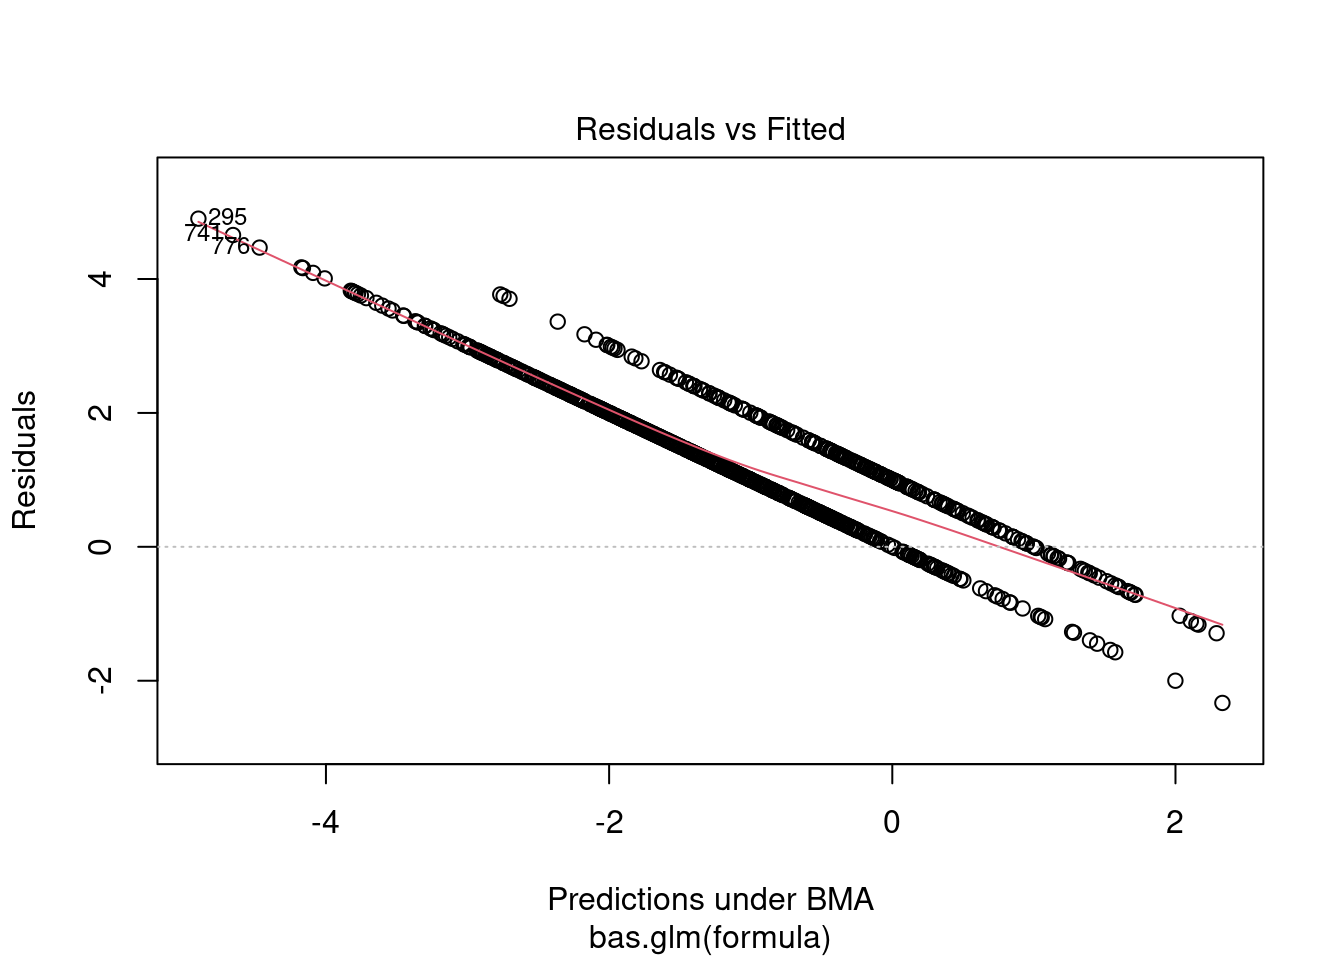

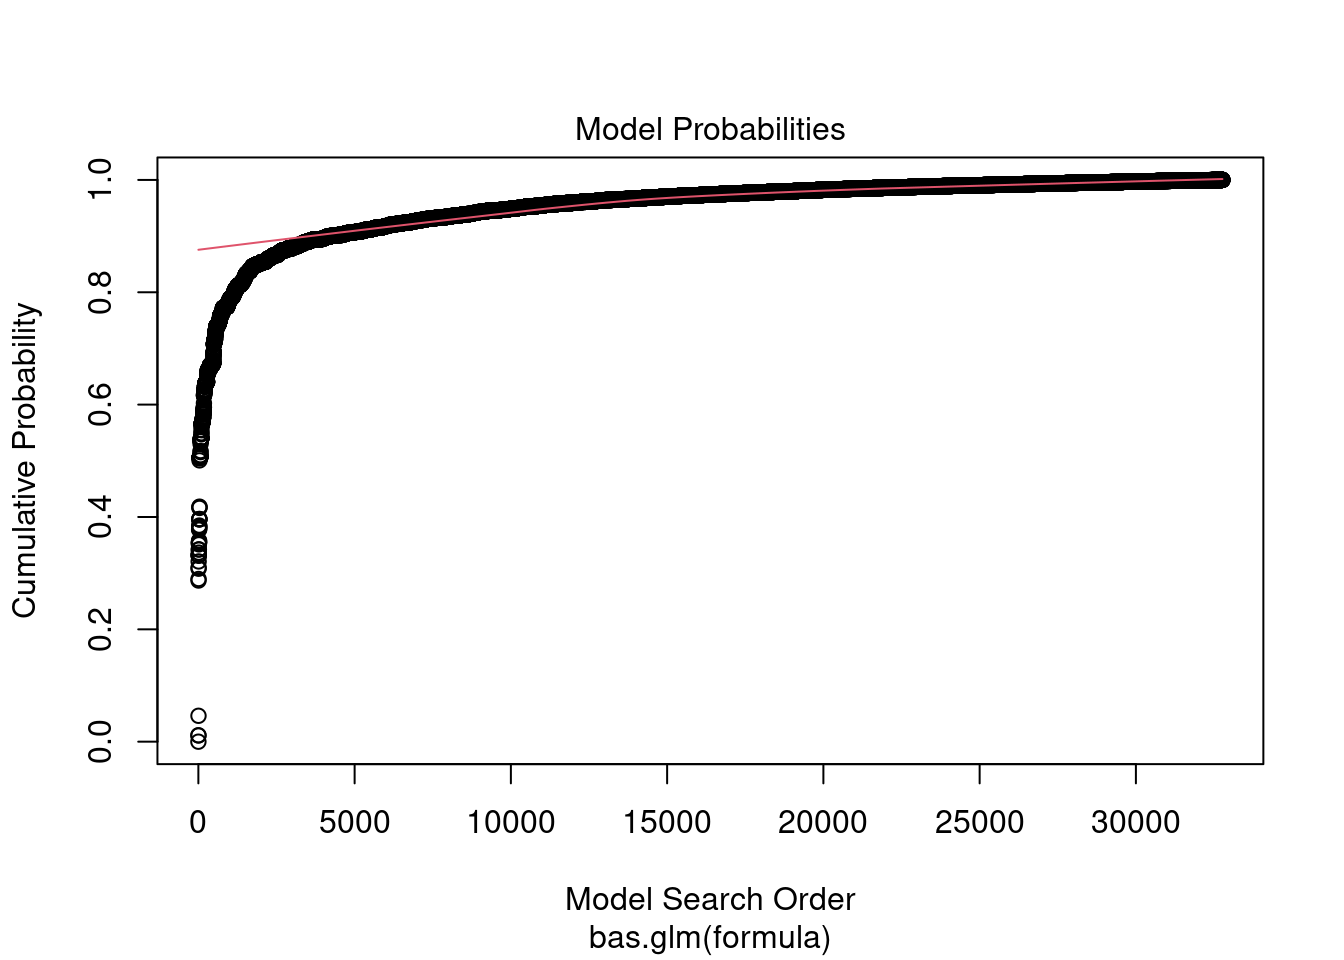

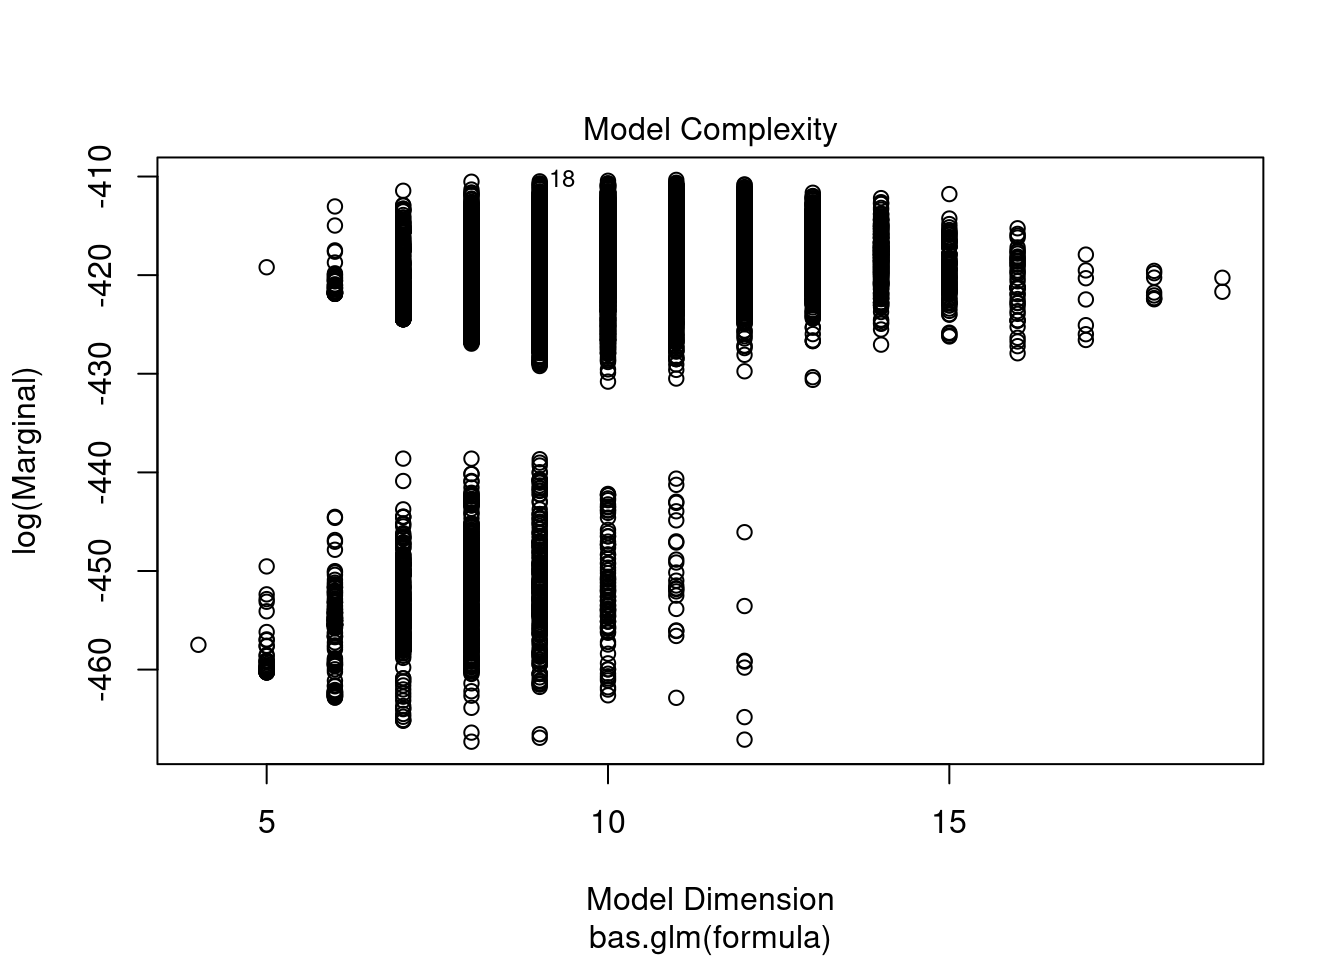

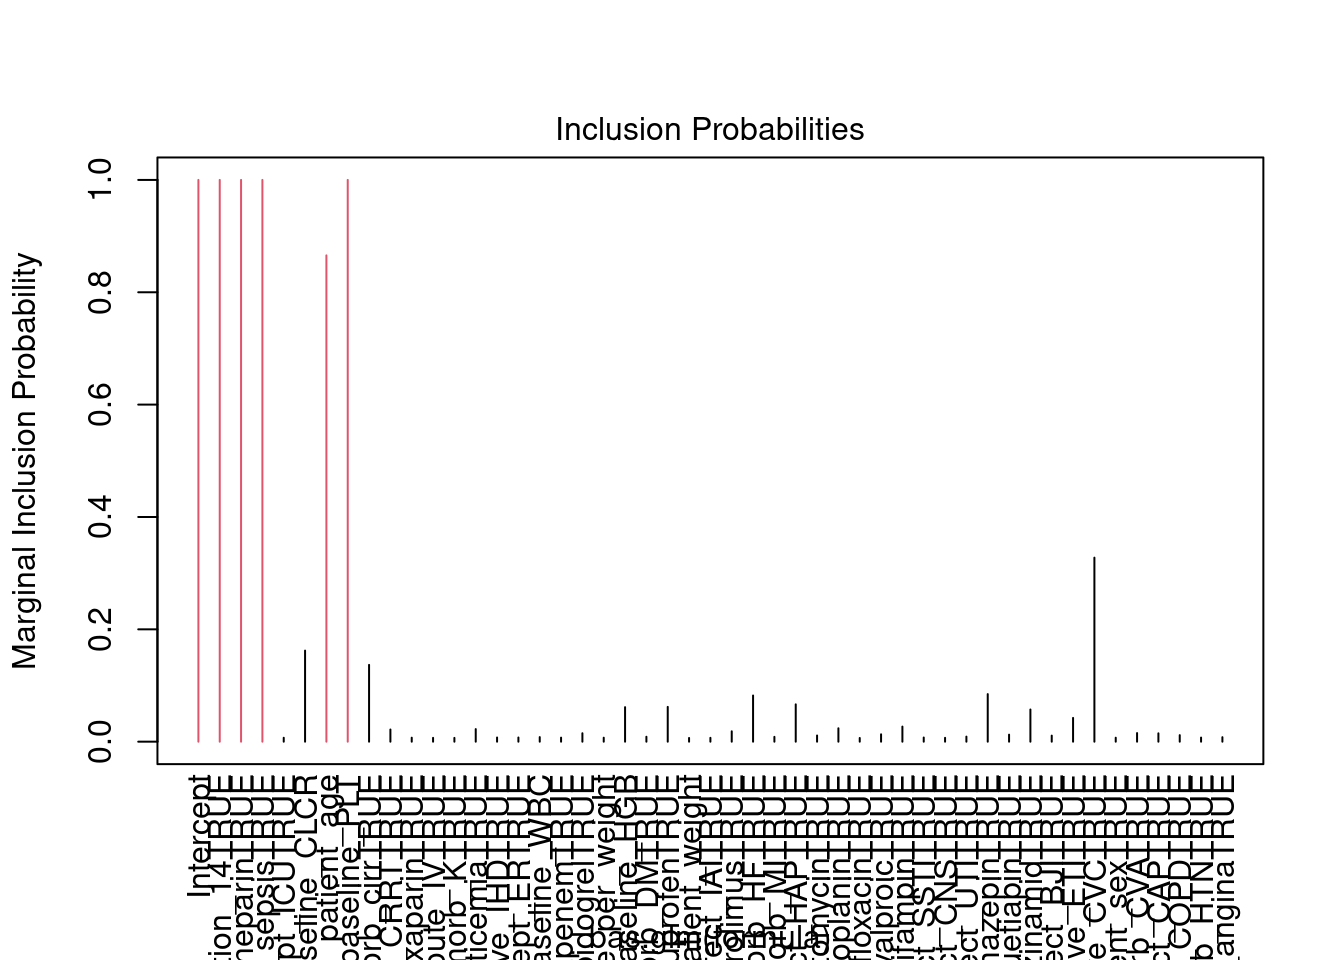

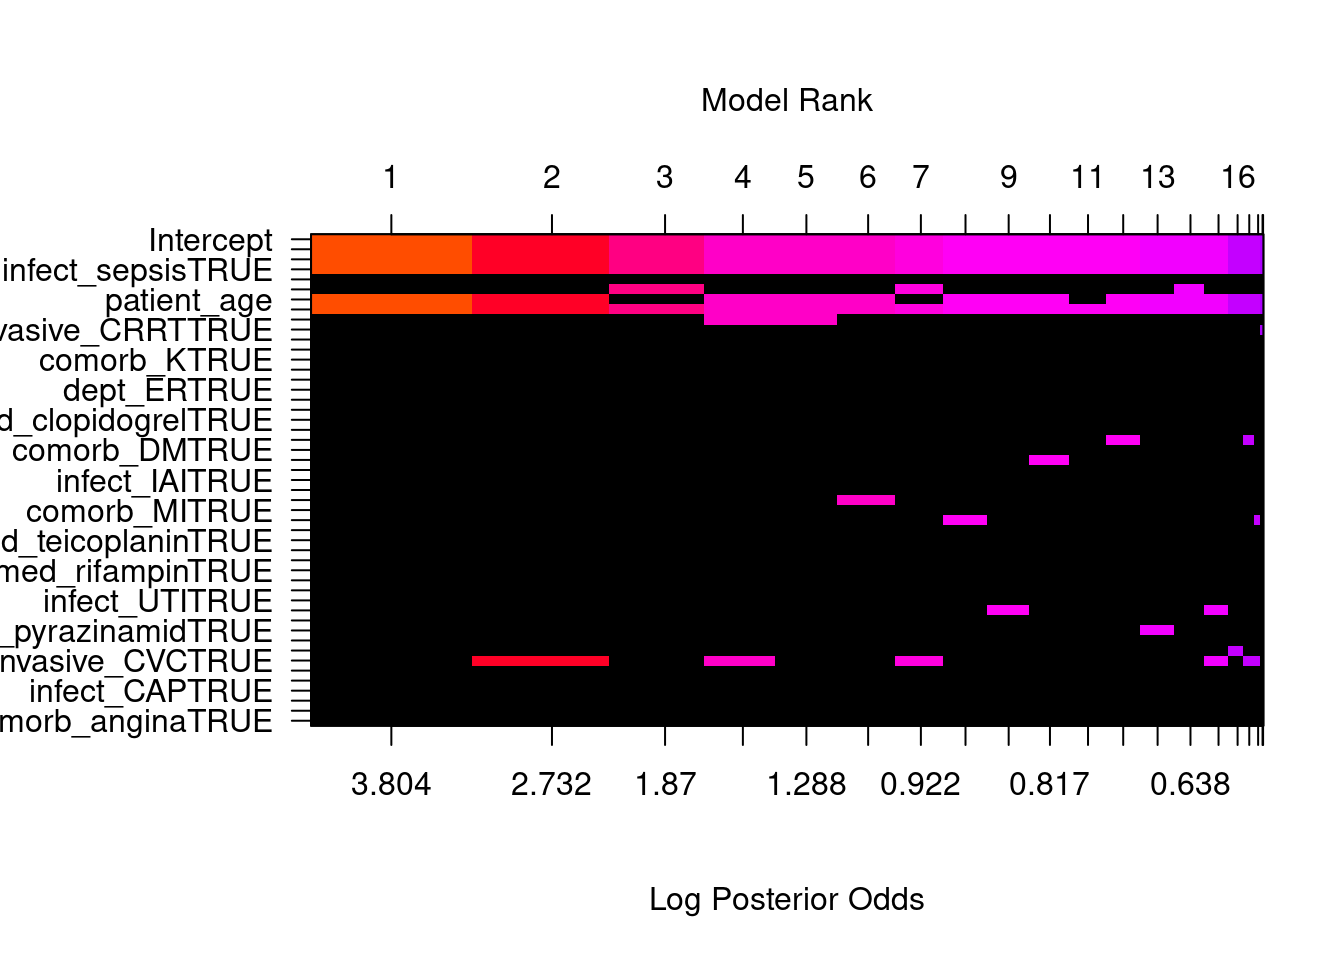

In [ ]:
library(tictoc)

tic()
multi_model_3_D <- data_patient_transformed |>
  select(all_of(variables_to_screen_all), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .,
    include.always = reformulate(variables_to_force_top_3),
    n.models = 2^15,
    thin = length(variables_to_screen_all),
    force.heredity = TRUE,
    method = "MCMC+BAS",
    update = 2^10
  )
toc()

In [ ]:
library(tidymodels)

model_basic_flow_3_D <- workflow() |>
  add_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_D)) |>
  add_model(logistic_reg())

model_full_BPM_3_D <- model_basic_flow_3_D |>
  update_variables(outcomes = "flag_ADR_TP_ID", predictors = all_of(multi_predict_BPM_3_D)) |>
  fit(data = data_patient_screen_full)

save(model_full_BPM_3_D, file = "data/model-performance/model-full-BPM-3-D.rda")

### Summary

In [ ]:
strategy_combos <- expand_grid(numbers = 1:3, chars = LETTERS[1:4])

model_file_list <- paste0(
  "data/model-performance/model-full-BPM-", 
  strategy_combos$numbers, "-", strategy_combos$chars, ".rda"
)

for (i in seq_along(model_file_list)) {
  model_file_list[i] |> load()
}

In [ ]:
library(tidymodels)

model_strategy_list <- paste0(
  "model_full_BPM_", strategy_combos$numbers, "_", strategy_combos$chars
) |> mget()

retrieve_terms <- function(model) {
  model |>
    tidy() |>
    filter(term != "(Intercept)") |>
    pull(term) |>
    str_remove("TRUE")
}

max_length <- map(model_strategy_list, retrieve_terms) |>
  map_int(length) |>
  max()

term_summary <- map(model_strategy_list, retrieve_terms) |>
  map(~ `length<-`(.x, max_length)) |>
  as_tibble()

``` r
term_summary |> knitr::kable()
```

  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  model_full_BPM_1_A   model_full_BPM_1_B   model_full_BPM_1_C   model_full_BPM_1_D   model_full_BPM_2_A   model_full_BPM_2_B   model_full_BPM_2_C   model_full_BPM_2_D   model_full_BPM_3_A   model_full_BPM_3_B   model_full_BPM_3_C   model_full_BPM_3_D
  -------------------- -------------------- -------------------- -------------------- -------------------- -------------------- -------------------- -------------------- -------------------- -------------------- -------------------- --------------------
  LZD_duration_14      LZD_duration_14      LZD_duration_14      LZD_duration_14      LZD_duration_14      LZD_duration_14      LZD_duration_14      LZD_duration_14      LZD_duration_14      LZD_duration_14      LZD_duration_14      LZD_duration_14

  comed_heparin        comed_heparin        comed_heparin        comed_heparin        comed_heparin        comed_heparin        comed_heparin        comed_heparin        comed_heparin        comed_heparin        comed_heparin        comed_heparin

  infect_sepsis        infect_sepsis        infect_sepsis        infect_sepsis        infect_sepsis        infect_sepsis        infect_sepsis        infect_sepsis        infect_sepsis        infect_sepsis        infect_sepsis        infect_sepsis

  baseline_CLCR        dept_ICU             dept_ICU             baseline_CLCR_30     patient_age          dept_ICU             dept_ICU             patient_age          patient_age          dept_ICU             dept_ICU             patient_age

  patient_age          baseline_CLCR        baseline_CLCR_30     patient_age          baseline_PLT         baseline_CLCR        baseline_CLCR_30     baseline_PLT         baseline_PLT         baseline_CLCR        baseline_CLCR_30     baseline_PLT

  baseline_PLT         patient_age          patient_age          baseline_PLT         invasive_IHD         baseline_PLT         patient_age          invasive_IHD         comed_enoxaparin     baseline_PLT         patient_age          invasive_IHD

  comorb_cirr          baseline_PLT         baseline_PLT         comorb_cirr          NA                   comed_carbapenem     baseline_PLT         NA                   invasive_CVC         comed_carbapenem     baseline_PLT         comed_levofloxacin

  NA                   NA                   comorb_cirr          NA                   NA                   NA                   NA                   NA                   NA                   comed_levofloxacin   patient_weight       comorb_HTN

  NA                   NA                   NA                   NA                   NA                   NA                   NA                   NA                   NA                   NA                   comed_levofloxacin   NA
  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Model Performance (completed in notebook 04, this will be removed)

In [ ]:
# library(CalibrationCurves)
# pHat <- predict(model_full_BPM$fit$fit$fit, data_patient_screen, type = "response")
# yTest <- data_patient_screen$flag_ADR_TP_ID |> as.logical()
# calperf <- valProbggplot(pHat, yTest)

# apparent_performance_metrics <- tibble(
#   cross_C_index = calperf$Cindex[[1]],
#   cross_C_index_lower = calperf$Cindex[[2]],
#   cross_C_index_upper = calperf$Cindex[[3]],
#   cross_calibration_intercept = calperf$Calibration$Intercept[[1]],
#   cross_calibration_intercept_lower = calperf$Calibration$Intercept[[2]],
#   cross_calibration_intercept_upper = calperf$Calibration$Intercept[[3]],
#   cross_calibration_slope = calperf$Calibration$Slope[[1]],
#   cross_calibration_slope_lower = calperf$Calibration$Slope[[2]],
#   cross_calibration_slope_upper = calperf$Calibration$Slope[[3]]
# ) |>
#   mutate(
#     cross_C_index_std_error = (cross_C_index_upper - cross_C_index_lower) / (2 * 1.96),
#     cross_calibration_intercept_std_error = (cross_calibration_intercept_upper - cross_calibration_intercept_lower) / (2 * 1.96),
#     cross_calibration_slope_std_error = (cross_calibration_slope_upper - cross_calibration_slope_lower) / (2 * 1.96)
#   ) |>
#   select(
#     cross_calibration_intercept, cross_calibration_intercept_std_error, cross_calibration_slope, cross_calibration_slope_std_error
#   ) |>
#   rename(
#     cal_in_the_large = cross_calibration_intercept, 
#     cal_in_the_large_std_error = cross_calibration_intercept_std_error, 
#     cal_slope = cross_calibration_slope, 
#     cal_slope_std_error = cross_calibration_slope_std_error) |>
#   pivot_longer(
#     cols = everything(),
#     names_to = c(".metric"),
#     values_to = c("mean")
#   ) |>
#   mutate(std_err = if_else(str_detect(.metric, "std_error"), mean, lead(mean))) |>
#   filter(!str_detect(.metric, "std_error")) |>
#   bind_rows(model_basic_performances |> collect_metrics())

# save(apparent_performance_metrics, file = "data/model-performance/apparent-performance-metrics.rda")

In [ ]:
# pHat <- predict(model_full_BPM$fit, data_patient_transformed, type = "response")
# yTest <- data_patient_transformed$flag_ADR_TP_ID
# calperf <- valProbggplot(pHat, yTest)

# apparent_performance_metrics_BPM <- tibble(
#   apparent_C_index = calperf$Cindex[[1]],
#   apparent_calibration_intercept = calperf$Calibration$Intercept[[1]],
#   apparent_calibration_slope = calperf$Calibration$Slope[[1]]
# )

# save(apparent_performance_metrics_BPM, file = "data/model-performance/apparent-performance-metrics-BPM.rda")

## Bayesian Generalized Additive Model (WIP)

In [ ]:
# library(spikeSlabGAM)
# run_spike_slab_GAM <- function(data, formula, ...) {
#   spikeSlabGAM(formula, data = data, family = "binomial", ...)
# }

# data_model <- data_patient_transformed |>
#   select(all_of(variables_to_screen), flag_ADR_TP_ID) |>
#   select(-c("baseline_CLCR_30", "baseline_CLCR_60", "LZD_duration_10", "baseline_PLT_150", "patient_age_65")) |>
#   as.data.frame()

# options(mc.cores = max(min(parallel::detectCores() - 1, 12), 2))

# model_0 <-
#   run_spike_slab_GAM(
#     data = data_model,
#     formula = reformulate(
#       termlabels = colnames(data_model) |> setdiff(c("flag_ADR_TP_ID")),
#       response = "flag_ADR_TP_ID"
#     )
#   )

# summary(model_0)
# plot(model_0)

## Nomogram with rms (WIP)

In [ ]:
# library(splines2)

# library(rms)

# data_patient_transformed |>
#   select(all_of(predictor_list), flag_ADR_TP_ID) |>
#   select_if(is.numeric) |>
#   map(quantile, probs = c(0, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1))

# dd <- data_patient_transformed |>
#   select(all_of(predictor_list), flag_ADR_TP_ID) |>
#   datadist()

# dd$limits$patient_age <- c(50, 62, 73, 19, 91, 19, 92)
# dd$limits$baseline_PLT <- c(143, 206, 288, 21, 433, 18, 434)
# dd$limits$baseline_CLCR <- c(21, 48, 84, 5, 184, 5, 189)
# dd$limits$LZD_duration <- c(6, 9, 14, 3, 26, 3, 28)

# options(datadist = "dd")
# nomo_obj <- lrm(flag_ADR_TP_ID ~ rcs(patient_age, 3) + rcs(baseline_PLT, 3) + rcs(baseline_CLCR, 3) + rcs(LZD_duration, 3) + invasive_CRRT + comed_heparin, data = data_patient_transformed) |>
#   nomogram(fun = plogis, funlabel = "Risk") |>
#   plot()

# for(k in 3:5) {
#   f <- lrm(flag_ADR_TP_ID ~ rcs(patient_age, k) + rcs(baseline_PLT, k) + rcs(baseline_CLCR, k) + rcs(LZD_duration, k) + invasive_CRRT * comed_heparin, data = data_patient_transformed)
#   cat('k=', k, '  AIC=', AIC(f), '\n')
# }

# print.nomogram <- function(x, dec = 0, ...) {
#   obj <- x
#   w <- diff(range(obj$lp$x)) / diff(range(obj$lp$x.real))
#   cat(
#     "Points per unit of linear predictor:", format(w),
#     "\nLinear predictor units per point   :", format(1 / w), "\n\n"
#   )

#   fun <- FALSE
#   for (x in names(obj)) {
#     k <- x == "total.points" || x == "lp" || x == "abbrev"
#     if (k) {
#       fun <- TRUE
#       next
#     }
#     y <- obj[[x]]
#     if (fun) {
#       z <- cbind(round(y[[1]], dec), y$x.real)
#       dimnames(z) <- list(rep("", nrow(z)), c("Total Points", x))
#     } else {
#       z <- cbind(format(y[[1]]), format(round(y$points, dec)))
#       dimnames(z) <- list(rep("", length(y$points)), c(x, "Points"))
#       ## didn't use data.frame since wanted blank row names
#     }
#     cat("\n")
#     print(z, quote = FALSE)
#     cat("\n")
#   }
#   invisible()
# }

# Check Model Assumptions

## Linearity

Visual check of linearity assumption using partial-residual plots (component+residual plots).

Blue dashed line: linear fit of the partial residuals.

Red line: smoothed conditional mean

The lines should be close together and the red line should be linear.

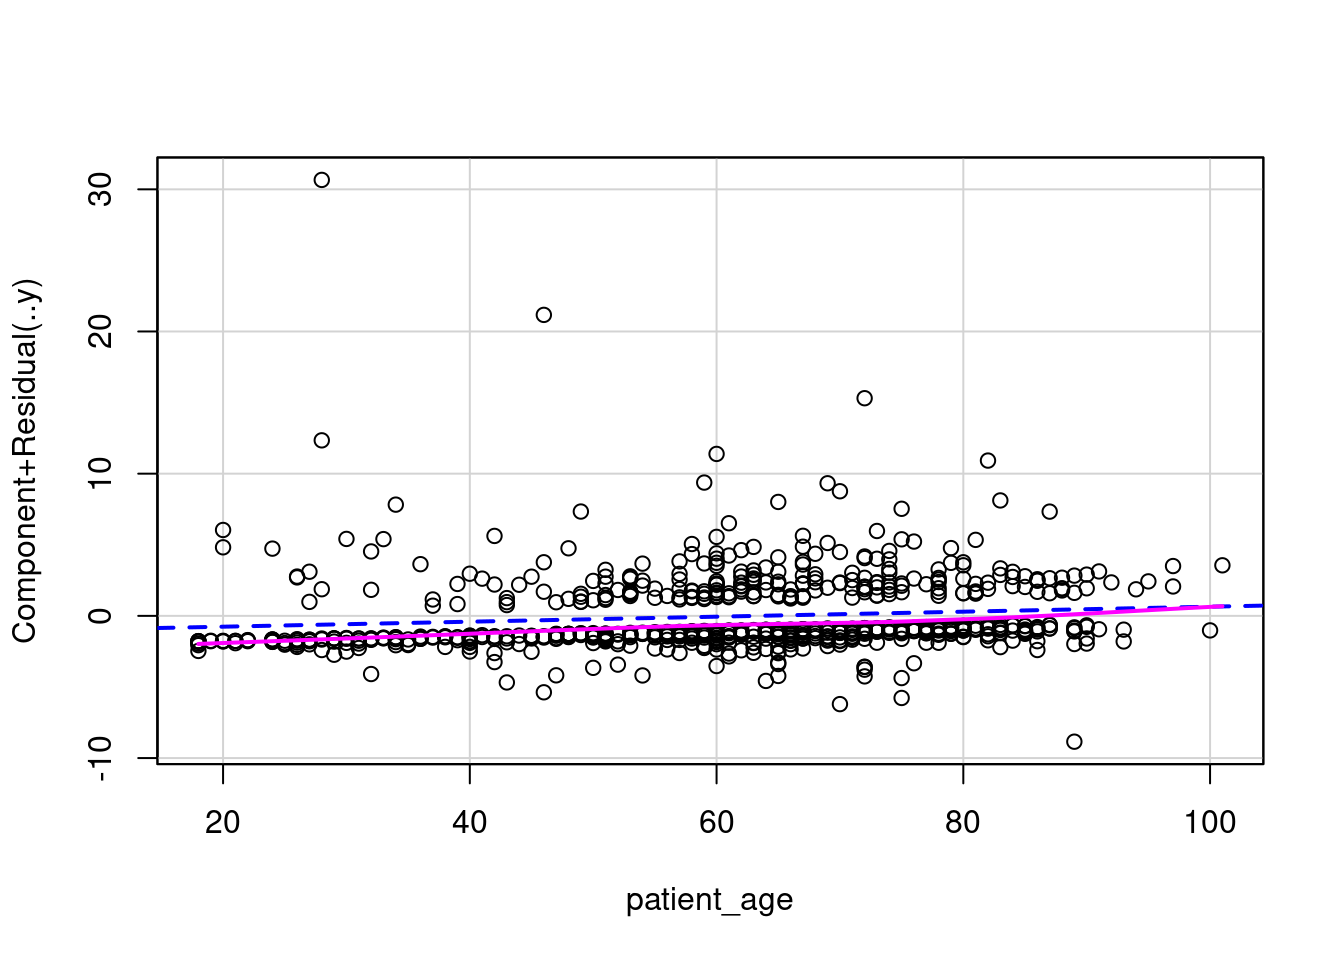

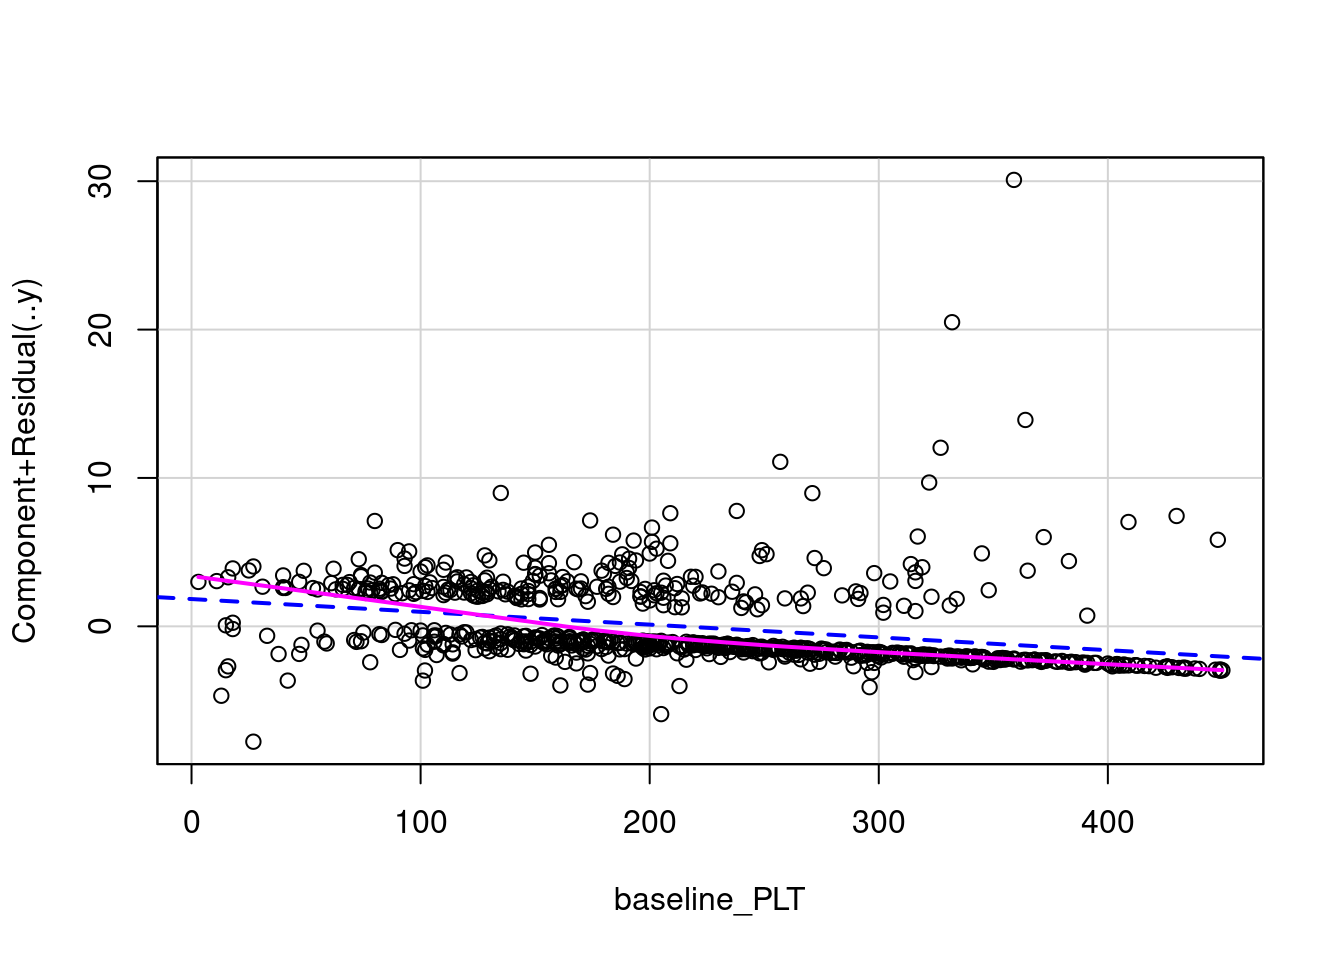

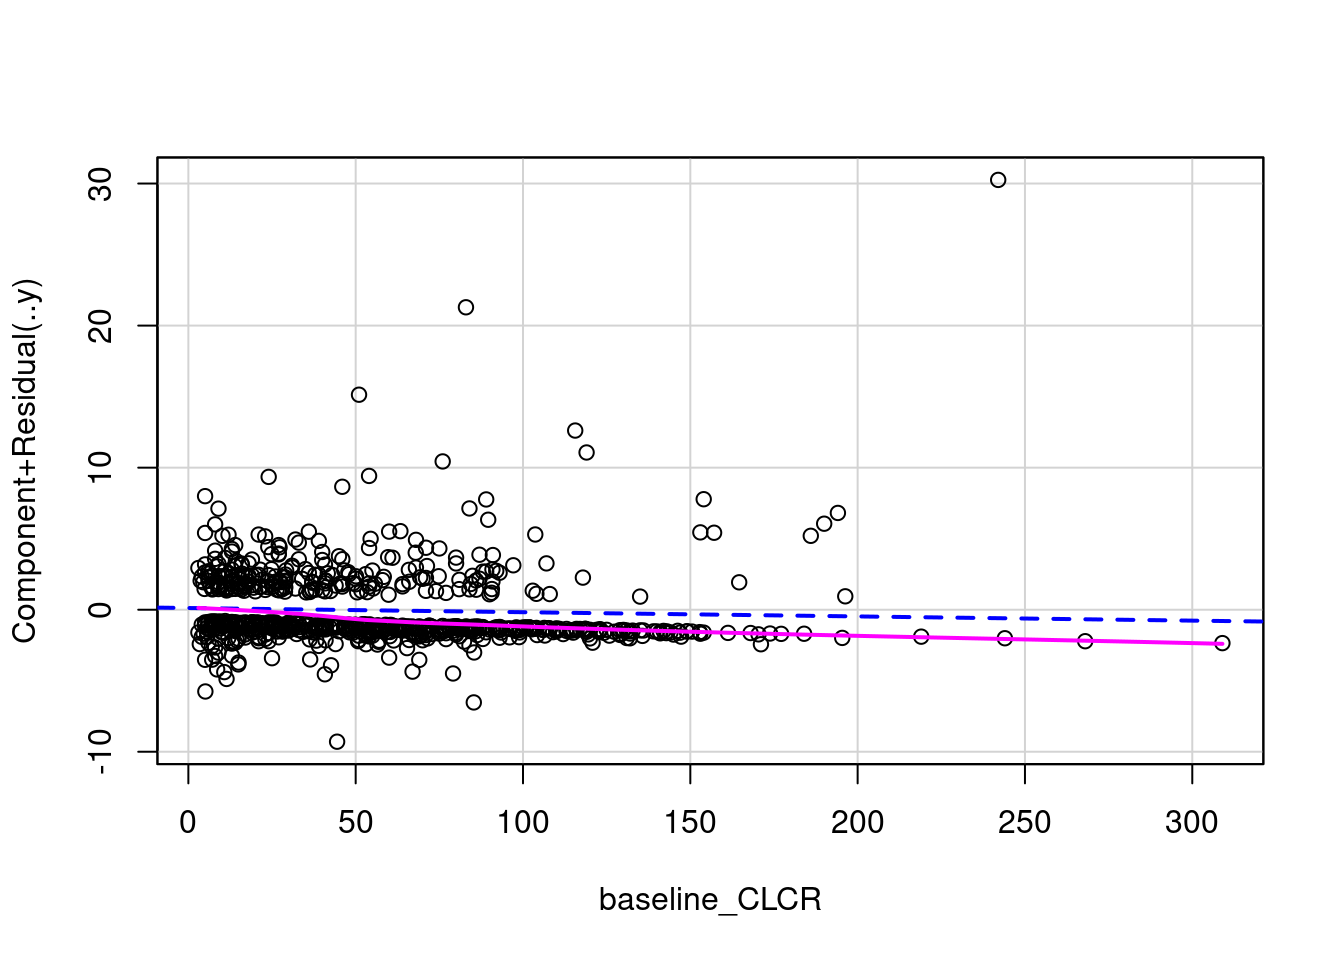

In [ ]:
# car::crPlot(model_full$fit, variable = "patient_age")
# car::crPlot(model_full$fit, variable = "baseline_PLT")

car::crPlot(model_full_BPM_1_A |> extract_fit_engine(), variable = "patient_age")

Result: No obvious non-linearity in the partial-residual plots.

Visual check of linearity assumption using logit of predicted probabilities vs. continuous predictors values.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

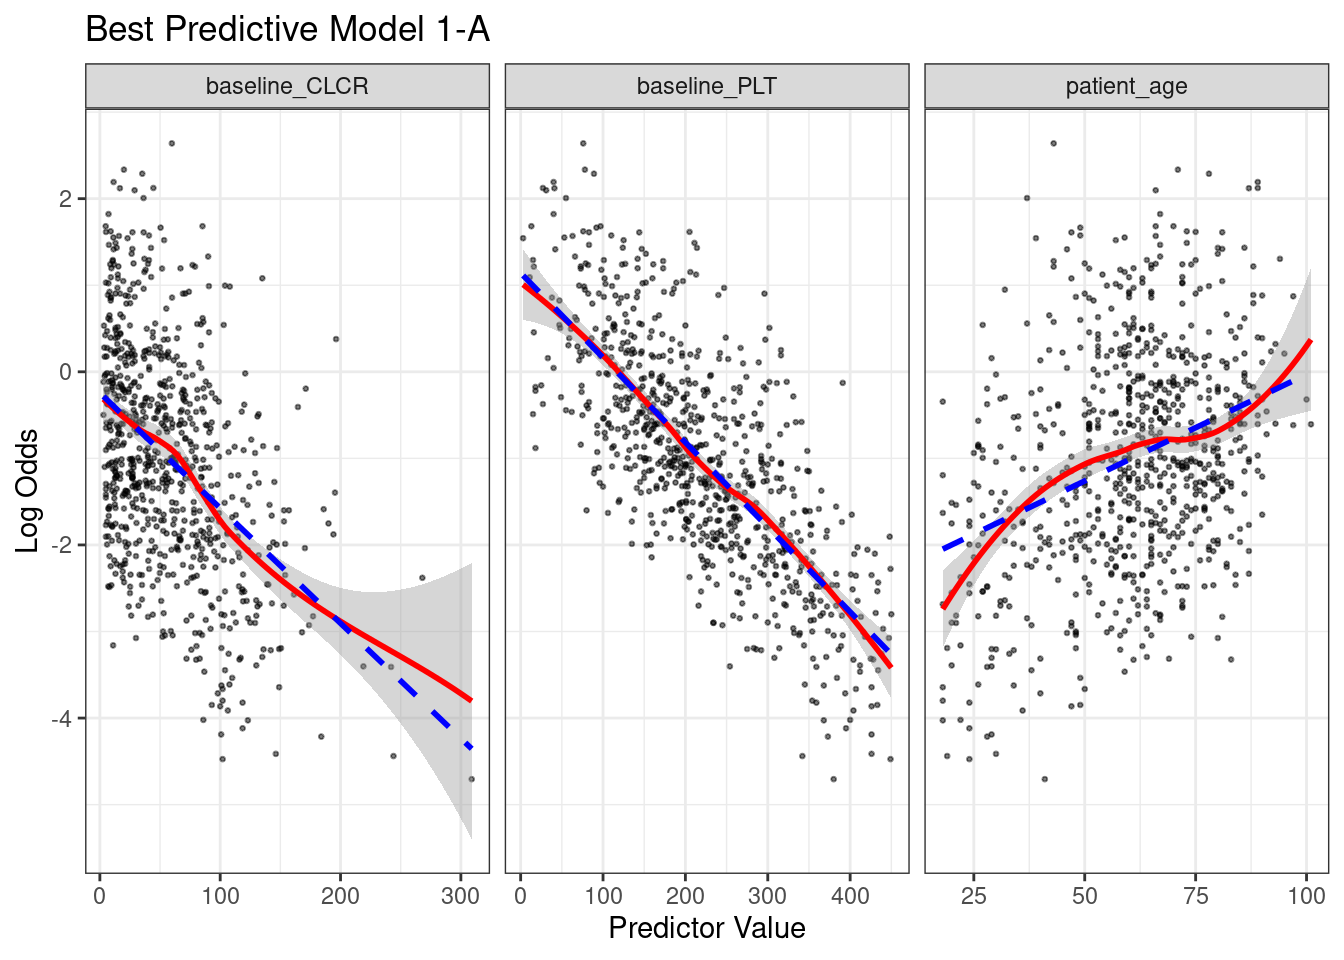

In [ ]:
# data_patient_linear_check <- data_patient_transformed |>
#   select(all_of(multi_predict_HPM)) |>
#   mutate(
#     probabilities = predict(model_full$fit, data_patient_transformed, type = "response"),
#     log_odds = log(probabilities / (1 - probabilities))
#   ) |>
#   select_if(is.numeric) |>
#   gather(key = "predictors", value = "predictor_value", -log_odds, -probabilities)

# ggplot(data_patient_linear_check, aes(y = log_odds, x = predictor_value)) +
#   geom_point(size = 0.5, alpha = 0.5) +
#   geom_smooth(method = "loess", color = "red") +
#   geom_smooth(method = "lm", linetype = "dashed", color = "blue", se = FALSE) +
#   theme_bw() +
#   facet_wrap(~predictors, scales = "free_x") +
#   labs(title = "Highest Probability Model", x = "Predictor Value", y = "Log Odds")

data_patient_linear_check_BPM <- data_patient_transformed |>
  select(all_of(multi_predict_BPM_1_A)) |>
  mutate(
    probabilities = predict(model_full_BPM_1_A |> extract_fit_engine(), data_patient_screen, type = "response"),
    log_odds = log(probabilities / (1 - probabilities))
  ) |>
  select_if(is.numeric) |>
  gather(key = "predictors", value = "predictor_value", -log_odds, -probabilities)

ggplot(data_patient_linear_check_BPM, aes(y = log_odds, x = predictor_value)) +
  geom_point(size = 0.5, alpha = 0.5) +
  geom_smooth(method = "loess", color = "red") +
  geom_smooth(method = "lm", linetype = "dashed", color = "blue", se = FALSE) +
  theme_bw() +
  facet_wrap(~predictors, scales = "free_x") +
  labs(title = "Best Predictive Model 1-A", x = "Predictor Value", y = "Log Odds")

## No Multicollinearity

VIFs from the coefficient estimates should be less than 5 and as close to 1 as possible.

In [ ]:
car::vif(model_full_BPM_1_A |> extract_fit_engine())

LZD_duration_14   comed_heparin   infect_sepsis   baseline_CLCR     patient_age 
       1.080494        1.068738        1.048423        1.248118        1.278326 
   baseline_PLT     comorb_cirr 
       1.101339        1.047271 

Result: VIFs are all less than 5 and close to 1.

## No Outlier Effects

Visual check from influence plot.

Individual observations should not have too much influence on the model.

Influence plot:

-   x-axis: Extreme values (Hat-values)
-   y-axis: Leverage (Studentized residuals)
-   Size of points: Cook’s distance

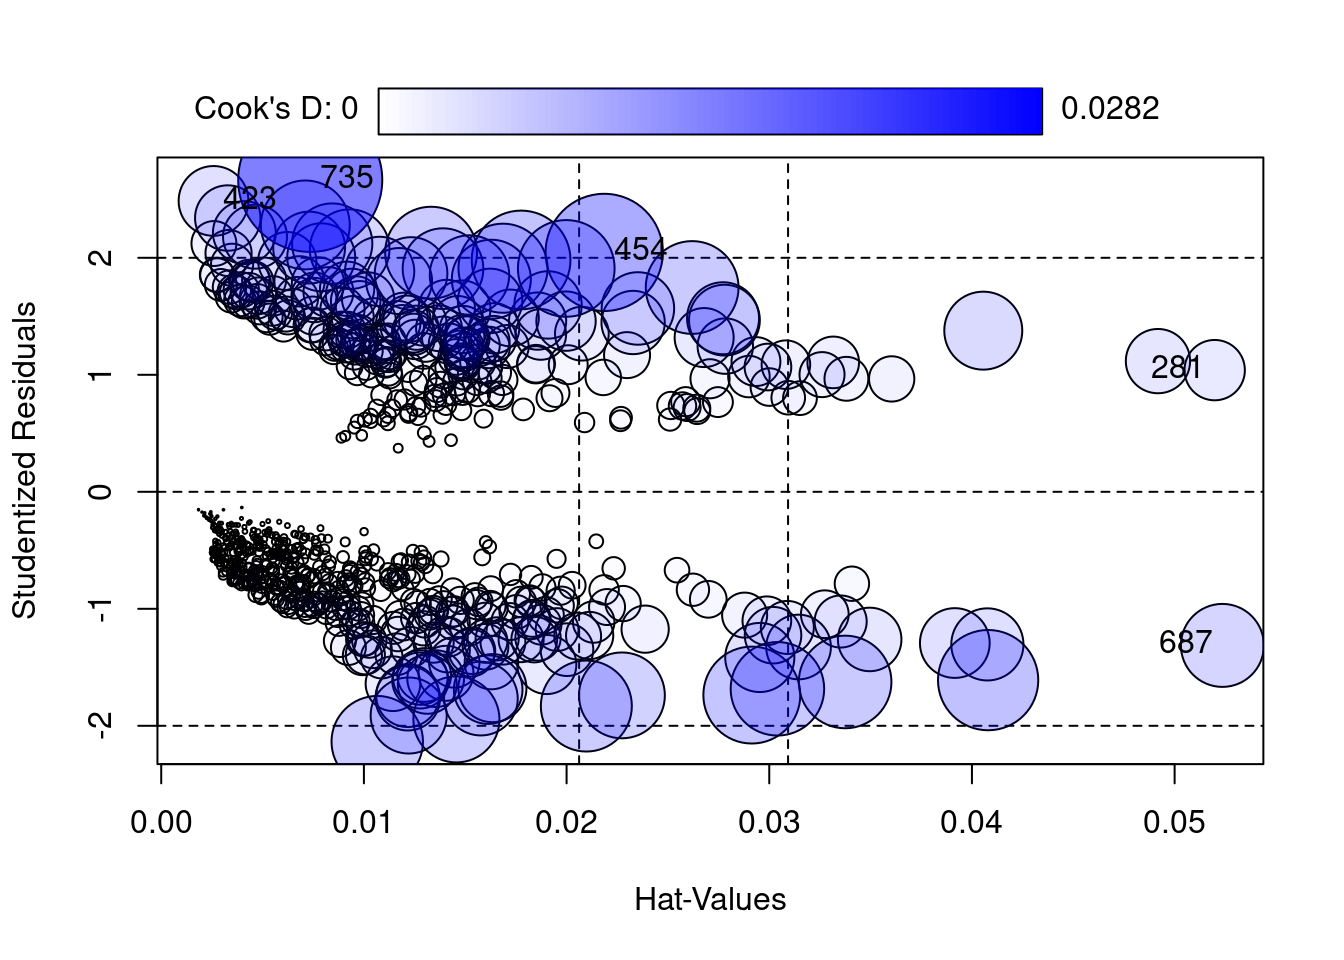

      StudRes         Hat       CookD
281  1.040040 0.051977028 0.004955398
423  2.486394 0.002580423 0.006622933
454  2.046298 0.021856232 0.018682386
687 -1.312956 0.052357529 0.009365878
735  2.665976 0.007352118 0.028204915

 [1]   6  14  69  99 119 132 146 148 208 213 251 281 290 305 312 320 323 325 332
[20] 349 364 379 409 423 460 483 552 572 598 642 653 687 716 735

In [ ]:
# car::influencePlot(model_full$fit)

car::influencePlot(model_full_BPM_1_A |> extract_fit_engine())

In [ ]:
# data_patient_transformed |>
#   slice(c(292, 301, 335, 364, 504, 634)) |> summary()

In [ ]:
# save(model_full, file = "data/model-performance/model-full.rda")
save(model_glmnet, file = "data/model-performance/model-glmnet.rda")